In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import talib as ta
from talib import MA_Type

In [12]:
#download stock data
stock_symbol = 'TSLA'
stock_data = yf.download(stock_symbol,  period="max")

# Create a Date column
stock_data['Date'] = stock_data.index
# Drop the Date as index
stock_data.reset_index(drop=True, inplace=True)
stock_data.head(5)

[*********************100%%**********************]  1 of 1 completed


Open      High       Low     Close  Adj Close     Volume       Date
0  1.266667  1.666667  1.169333  1.592667   1.592667  281494500 2010-06-29
1  1.719333  2.028000  1.553333  1.588667   1.588667  257806500 2010-06-30
2  1.666667  1.728000  1.351333  1.464000   1.464000  123282000 2010-07-01
3  1.533333  1.540000  1.247333  1.280000   1.280000   77097000 2010-07-02
4  1.333333  1.333333  1.055333  1.074000   1.074000  103003500 2010-07-06

In [17]:
stock_data.tail(5)

Open        High         Low       Close   Adj Close     Volume  \
3547  214.880005  216.130005  205.779999  207.669998  207.669998   82880100   
3548  185.220001  203.880005  182.000000  198.880005  198.880005  100308800   
3549  200.750000  202.899994  192.669998  200.639999  200.639999   73783900   
3550  200.770004  203.490005  191.479996  191.759995  191.759995   71159800   
3551  195.699997  200.699997  192.039993  198.839996  198.839996   63967317   

           Date        RSI  
3547 2024-08-02  46.623553  
3548 2024-08-05  44.144089  
3549 2024-08-06  44.761686  
3550 2024-08-07  42.284771  
3551 2024-08-08  44.840048

In [14]:
#Clean data 
dt_all = pd.date_range(start=stock_data.index[0],end=stock_data.index[-1])

dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(stock_data.index)]

dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]

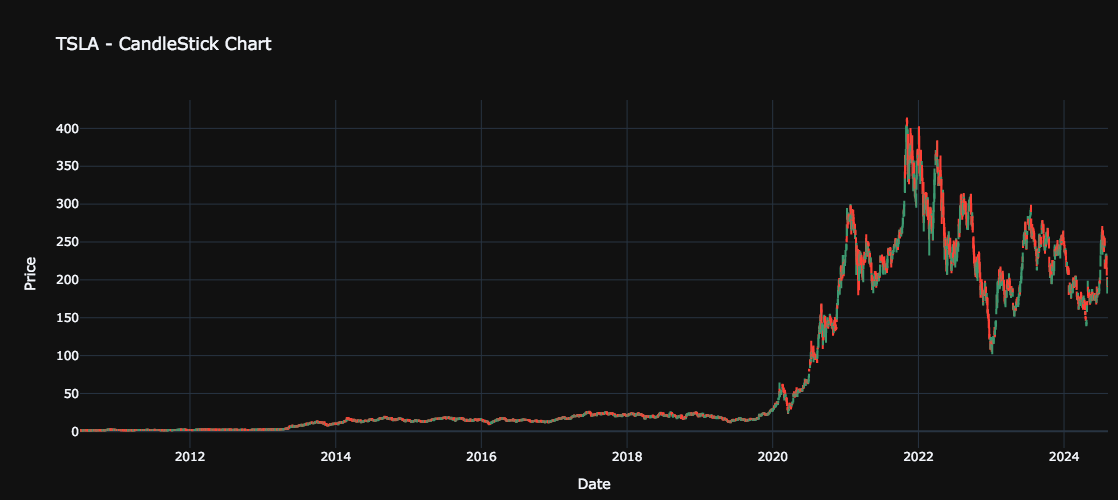

In [15]:
#Plot candlesticks
fig = go.Figure(data=[go.Candlestick(x=stock_data['Date'], open=stock_data['Open'],
                                     high=stock_data['High'], low=stock_data['Low'],
                                     close=stock_data['Close'])])

# Sets customized padding
fig.update_layout(margin=go.layout.Margin(r=10,b=10))

# Remove dates without values
fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])

fig.update_yaxes(title_text='Price')
fig.update_xaxes(title_text='Date')

fig.update_layout(title = stock_symbol + ' - CandleStick Chart',
                  xaxis_rangeslider_visible=False,
                  height=500, template='plotly_dark')

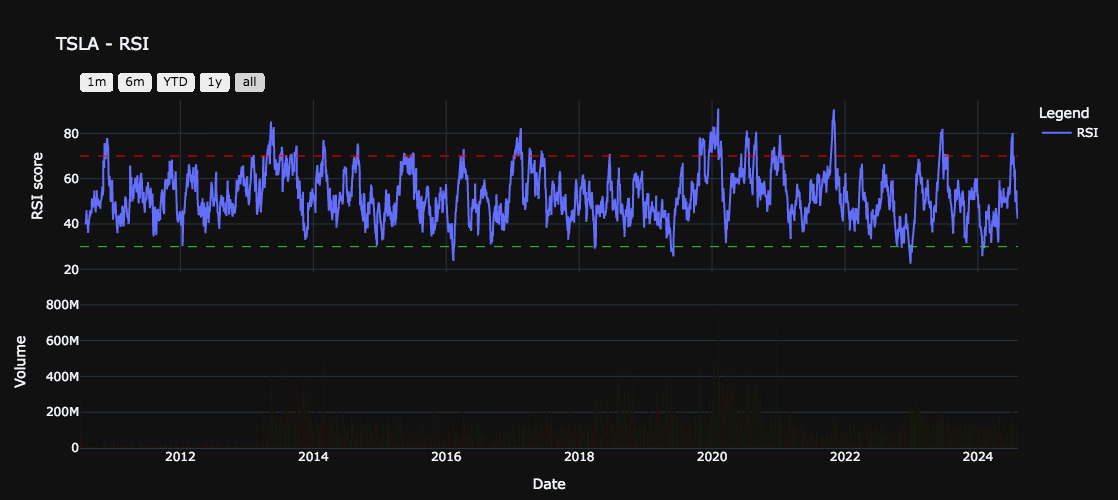

In [16]:
#Plot RSI
# RSI
stock_data['RSI'] = ta.RSI(stock_data.Close,21)

# Construct a 2 x 1 Plotly figure
fig = make_subplots(rows=2, cols=1, vertical_spacing=0.01, shared_xaxes=True)

# Plot RSI
fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['RSI'], name='RSI'),
              row=1, col=1)

fig.add_hline(y=30, line_dash='dash', line_color='limegreen', line_width=1)
fig.add_hline(y=70, line_dash='dash', line_color='red', line_width=1)
fig.update_yaxes(title_text='RSI Score')

colors = ['#9C1F0B' if row['Open'] - row['Close'] >= 0
      else '#2B8308' for index, row in stock_data.iterrows()]


fig.add_trace(go.Bar(x=stock_data['Date'], y=stock_data['Volume'], 
                     showlegend=False, marker_color=colors), row=2, col=1)

# Adds the range selector
fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=[
                    dict(count=1, label='1m', step='month', stepmode='backward'),
                    dict(count=6, label='6m', step='month', stepmode='backward'),
                    dict(count=1, label='YTD', step='year', stepmode='todate'),
                    dict(count=1, label='1y', step='year', stepmode='backward'),
                    dict(step='all')
                ]),
            type='date'),
        xaxis2_type='date')

# Set the color from white to black on range selector buttons
fig.update_layout(xaxis=dict(rangeselector = dict(font = dict( color = 'black'))))

# Sets customized padding
fig.update_layout(margin=go.layout.Margin(r=10, b=10)) 

# Remove dates without values
fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])

fig['layout']['yaxis']['title']='RSI score'
fig['layout']['yaxis2']['title']='Volume'
fig['layout']['xaxis2']['title']='Date'

layout = go.Layout(template='plotly_dark', title=stock_symbol + ' - RSI',
                   height=500, legend_title='Legend',
                   xaxis=dict(rangeselector = dict(font = dict( color = 'black'))))
fig.update_layout(layout)

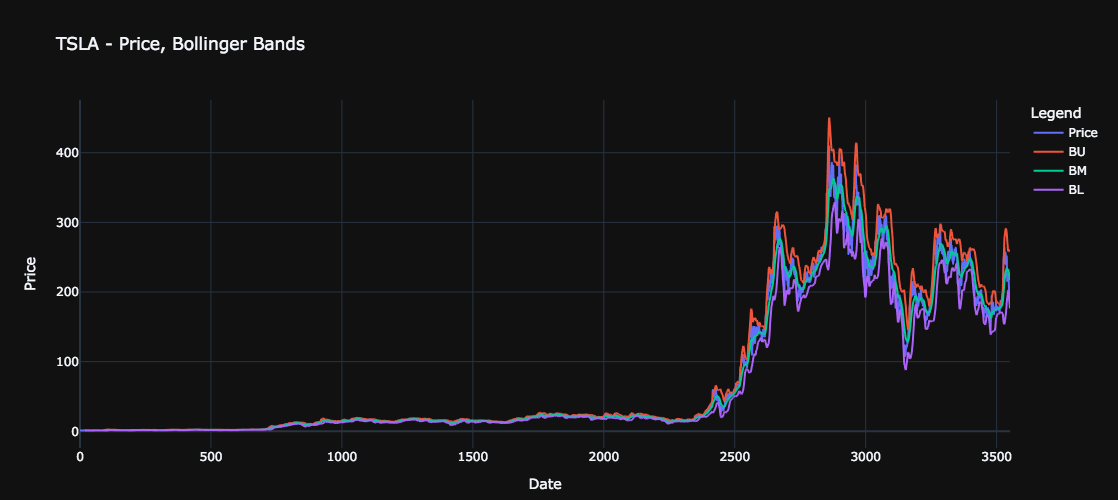

In [20]:
#Plot Bollinger Bands
stock_data['BU'], stock_data['BM'], stock_data['BL'] = ta.BBANDS(stock_data.Close,
                                                                 timeperiod=20,
                                                                 matype=MA_Type.EMA)
fig = px.line(data_frame = stock_data, x = stock_data.index,
              y = ['Close', 'BU', 'BM', 'BL'])

# Update y & x axis labels
fig.update_yaxes(title_text='Price')
fig.update_xaxes(title_text='Date')
    
fig.data[0].name = 'Price'

# Sets customized padding
fig.update_layout(margin=go.layout.Margin(
        r=10,
        b=10))

layout = go.Layout(template='plotly_dark', 
                   title=stock_symbol + ' - Price, Bollinger Bands',
                   height=500, legend_title='Legend')
fig.update_layout(layout)

In [21]:
#adding signal rules 
# Drop Buy and Sell columns if they exist
stock_data.drop(['Buy', 'Sell'], inplace=True, axis=1, errors='ignore')    

# Create DataFrame
df_buy = stock_data.query('Low < BL')[['Date', 'Close']]
df_sell = stock_data.query('High > BU')[['Date', 'Close']]

# Round close values for both buy and sell
df_buy['Close'] = round(df_buy.Close.round())
df_sell['Close'] = round(df_sell.Close.round())

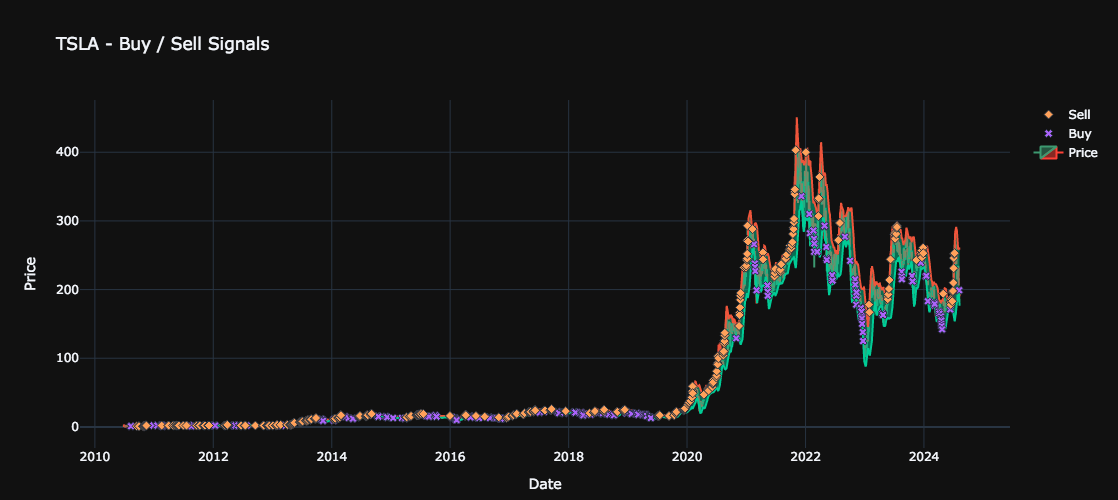

In [22]:
fig = go.Figure(data=[go.Candlestick(x=stock_data['Date'], open=stock_data['Open'],
                                     high=stock_data['High'],
                                     low=stock_data['Low'],
                                      close=stock_data['Close'],
                                      name='Candlestick')])

# Plot BU line graph; don't show legend
fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['BU'],
                         fill=None, mode='lines', showlegend=False))

# Plot BL line graph and fill upto BU; don't show legend
fig.add_trace(go.Scatter(x=stock_data['Date'], y=stock_data['BL'],
                         fill='tonexty', mode='lines', showlegend=False))

# Plot Buy signals
fig.add_trace(go.Scatter(x=df_buy['Date'], y=df_buy['Close'], mode='markers',
    marker=dict(symbol='x', size=7, line=dict(width=1)), name = 'Buy'))

# Plot Sell Signls
fig.add_trace(go.Scatter(x=df_sell['Date'], y=df_sell['Close'], mode='markers',
    marker=dict(symbol='diamond', size=7, line=dict(width=1)), name = 'Sell'))

fig.update_yaxes(title_text='Price')
fig.update_xaxes(title_text='Date')
    
fig.data[0].name = 'Price'
fig.update_layout(margin=go.layout.Margin(r=10,b=10))

layout = go.Layout(template='plotly_dark',
                   title =stock_symbol + ' - Buy / Sell Signals', height=500,
                    xaxis_rangeslider_visible=False)
fig.update_layout(layout)

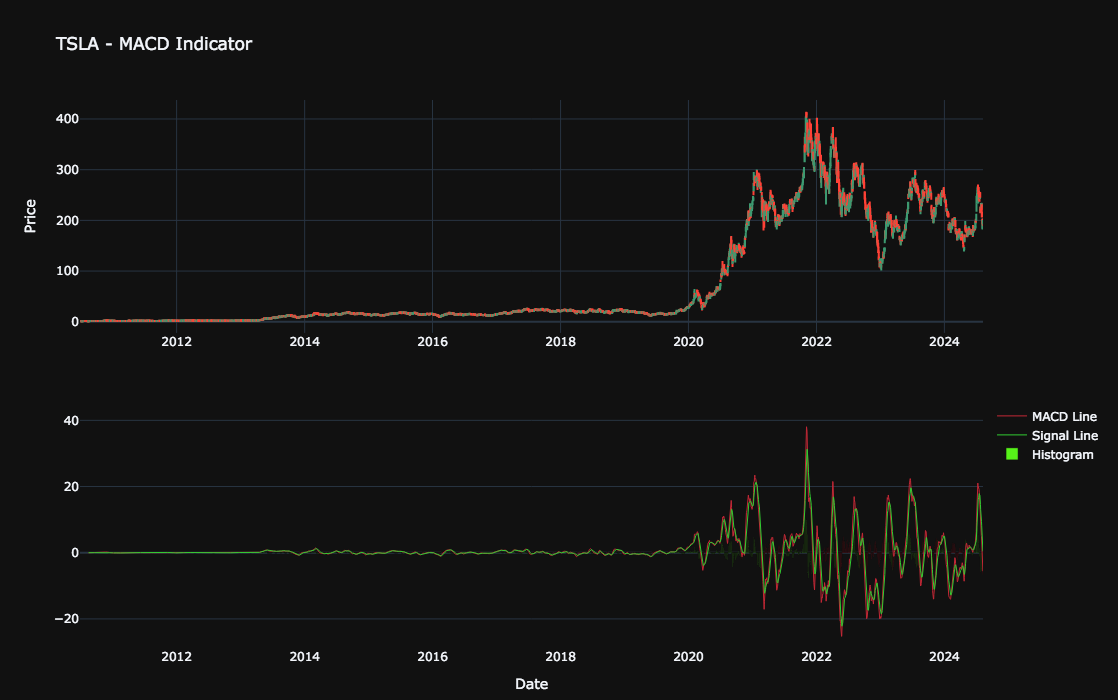

In [23]:
#Plot MACD

# Calculate MACD values
# Empty Data Frame to collect MACD analysis results
analysis = pd.DataFrame()
analysis['macd'], analysis['macdSignal'],analysis['macdHist'] = ta.MACD(stock_data.Close,
                                                                fastperiod=12,
                                                                slowperiod=26,
                                                                signalperiod=9)
fig = make_subplots(rows=2, cols=1)

# Candlestick chart for pricing
fig.append_trace(go.Candlestick(x=stock_data['Date'], open=stock_data['Open'],
                                high=stock_data['High'], low=stock_data['Low'],
                                close=stock_data['Close'], showlegend=False),
                                row=1, col=1)

# Fast Signal (%k)
fig.append_trace(go.Scatter(x=stock_data['Date'],
                            y=analysis['macd'],
                            line=dict(color='#C42836', width=1),
                            name='MACD Line'), row=2, col=1)

# Slow signal (%d)
fig.append_trace(go.Scatter(x=stock_data['Date'], y=analysis['macdSignal'],
                            line=dict(color='limegreen', width=1),
                            name='Signal Line'), row=2, col=1)

# Colorize the histogram values
colors = np.where(analysis['macd'] < 0, '#EA071C', '#57F219')

# Plot the histogram
fig.append_trace(go.Bar(x=stock_data['Date'], y=analysis['macdHist'],
                        name='Histogram', marker_color=colors),
                       row=2, col=1)

fig['layout']['yaxis']['title']='Price'
fig['layout']['xaxis2']['title']='Date'

fig.data[0].name = 'Price'

# Sets customized padding
fig.update_layout(margin=go.layout.Margin(r=10, b=10)) 

# Make it pretty
layout = go.Layout(template='plotly_dark', title = stock_symbol + ' - MACD Indicator', height=700,
    xaxis_rangeslider_visible=False)

# Update options and show plot
fig.update_layout(layout)

fig.update_layout(legend=dict(yanchor="top", y=0.45, xanchor="left", x=1.01))
fig.show()